Import Dependencies

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from scipy import stats

Load  data into a  DataFrame

In [2]:
# Load the data
mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')

# Keep only necessary columns
mb_clean_frame = mb_raw_data[['Sequence', 'm/z', 'CCS','Mass','Charge','Length']]
# Group by 'Sequence' and 'Charge', and calculate median of 'Mass' and 'CCS'
mb_clean_frame = mb_clean_frame.groupby(['Sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()


# Perform z-score transformation
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])

# Save the mean and std for later use
ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# Delete the raw data frame to save memory
del mb_raw_data
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)

Train Model

In [3]:
# Split the data into input (m/z) and output (CCS) variables
X = mb_clean_frame[["Charge", 'Mass', 'Length']]
y = mb_clean_frame['CCS_z']

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create dataframe for test data
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)


# Define the number of folds
k = 4

In [4]:
# all test data in one df
test_data = pd.concat([X_test_df, y_test_df], axis=1)

# add CCS column for later correlation check
ccs_test = mb_clean_frame['CCS'].loc[X_test_df.index]

# Add the ccs values to your test DataFrame
test_data = pd.concat([test_data, ccs_test], axis=1)

# Save the mean and std for later use
ccs_mean = test_data['CCS'].mean()
ccs_std = test_data['CCS'].std()



In [16]:
test_data

,Charge,Mass,Length,CCS_z,CCS
0,2,1746.820660,16,-0.115792,2.654046e-35
1,2,1637.844690,16,-0.058908,5.996674e-36
2,3,2204.100800,19,1.598230,5.956918e-36
3,2,2299.021550,19,-0.381034,5.996673e-36
4,1,754.415980,7,-1.224706,5.970114e-36
...,...,...,...,...,...
88148,2,2193.084130,21,-0.347663,2.744804e-35
88149,2,1516.763410,13,0.026453,1.298234e-35
88150,2,1599.746370,12,0.103424,2.744804e-35
88151,2,2072.024840,20,-0.286176,1.298234e-35


Perform k-fold cross validation

In [5]:
# Start logging time in ms without
start_time = time.time()
# Initialize the cross-validation object
kf = KFold(n_splits=k)
# Initialize a list to store the MSE for each fold
mse_scores = []
median_relative_errors = []
r2_scores = []
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Create a linear regression model
    model = LinearRegression(n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Convert predictions back to original scale
    y_pred_orig = y_pred * ccs_std + ccs_mean
    y_test_orig = y_test * ccs_std + ccs_mean

    # Calculate the MSE for the current fold
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    mse_scores.append(mse)
    # Calculate the median relative error for the current fold
    relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    median_relative_error = np.median(relative_errors)
    median_relative_errors.append(median_relative_error)
    # Calculate the R^2 score for the current fold
    r2 = r2_score(y_test_orig, y_pred_orig)
    r2_scores.append(r2)
    # Progress update
    print("Fold:", len(mse_scores))

# Create the final model
final_model = LinearRegression(n_jobs=-1)
final_model.fit(X_train, y_train)

# Print the average MSE score
print("Average Mean Squared Error:", np.mean(mse_scores))
# print the average of the median relative errors
print("Average Median Relative Error:", np.mean(median_relative_errors))
# Print the average R^2 score
print("Average R^2 Score:", np.mean(r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 1.1351919832231031e-72
Average Median Relative Error: 0.03487491356274562
Average R^2 Score: 0.9832896122833019
Time elapsed: 0.11 seconds


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Start logging time in ms without
start_time = time.time()

# Define the number of folds
k = 4

# Define the number of trees in the random forest
n = 50

# Initialize the cross-validation object
kf = KFold(n_splits=k)

# Initialize lists to store the corrected MSE, median relative error and R^2 score for each fold
corrected_mse_scores = []
corrected_median_relative_errors = []
corrected_r2_scores = []
y_pred = final_model.predict(X_train)
# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Progress update
    print("Fold:", len(corrected_mse_scores) + 1)
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Predict the CCS values on the training set
    y_train_pred = final_model.predict(X_train)

    # Calculate the residuals from the linear regression model
    residuals = y_train - y_train_pred

    # Train a RF model on the residuals
    rf_model = RandomForestRegressor(n_estimators=n, n_jobs=-1)
    rf_model.fit(X_train, residuals)

    # Predict the residuals on the test set
    residuals_pred = rf_model.predict(X_test)
    
    # Predict the CCS values on the test set
    y_test_pred = final_model.predict(X_test)
    # Correct the initial predictions with the predicted residuals
    corrected_y_pred = y_test_pred + residuals_pred
    
    # Convert predictions back to original scale
    y_pred_orig = corrected_y_pred * ccs_std + ccs_mean
    y_test_orig = y_test * ccs_std + ccs_mean
    
    # Calculate the corrected MSE, median relative error and R^2 score for the current fold
    corrected_mse = mean_squared_error(y_test_orig, y_pred_orig)
    corrected_relative_errors = np.abs((y_pred_orig - y_test_orig) / y_test_orig)
    corrected_median_relative_error = np.median(corrected_relative_errors)
    corrected_r2 = r2_score(y_test_orig, y_pred_orig)


    # Append the scores to their respective lists
    corrected_mse_scores.append(corrected_mse)
    corrected_median_relative_errors.append(corrected_median_relative_error)
    corrected_r2_scores.append(corrected_r2)

# Create the final model
print("prediction: ", len(y_pred), "y training: ", len(y_train), "x training: ", len(X_train))
final_residual_model = RandomForestRegressor(n_estimators=n, n_jobs=-1)
final_residual_model.fit(X_train, y_train - y_pred)
# Print the average corrected MSE, median relative error and R^2 score
print("Average Corrected Mean Squared Error:", np.mean(corrected_mse_scores))
print("Average Corrected Median Relative Error:", np.mean(corrected_median_relative_errors))
print("Average Corrected R^2 Score:", np.mean(corrected_r2_scores))
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f'Time elapsed: {elapsed_time:.2f} seconds')


Fold: 1
Fold: 2
Fold: 3
Fold: 4
prediction:  173709 y training:  173709 x training:  173709
Average Corrected Mean Squared Error: 7.500534068972667e-73
Average Corrected Median Relative Error: 0.01789678305590813
Average Corrected R^2 Score: 0.9889588572064214
Time elapsed: 19.21 seconds


In [7]:
# Predict the CCS (corrected) of the peptides in the data frame with the test data
test_data['Predicted CCS Corrected z'] = final_model.predict(X_test_df) + final_residual_model.predict(X_test_df)

# Reverse the z-score transformation
test_data['Predicted CCS Corrected'] = test_data['Predicted CCS Corrected z'] * ccs_std + ccs_mean


In [8]:
# final model parameters Ensemble Model
r2 = r2_score(test_data['CCS_z'], test_data['Predicted CCS Corrected z'])
mse = mean_squared_error(test_data['CCS_z'], test_data['Predicted CCS Corrected z'])
relative_errors = np.abs((test_data['Predicted CCS Corrected z'] - test_data['CCS_z']) / test_data['CCS_z'])
median_relative_error = np.median(relative_errors)
print("Average Corrected Mean Squared Error:", np.mean(mse))
print("Average Corrected Median Relative Error:", median_relative_error)
print("Average Corrected R^2 Score:", np.mean(r2))

Average Corrected Mean Squared Error: 0.0040420591915437875
Average Corrected Median Relative Error: 0.03324029283534548
Average Corrected R^2 Score: 0.9959332420184488


Spearman's Correlation Coefficient: 0.9982319288771624
Pearson's Correlation Coefficient: 0.9985186122906494
This is correlation on the test dataset, which has size: 88153 
 the whole dataset is 440762


/opt/anaconda3/envs/pbl/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Length', ylabel='Percent Error'>

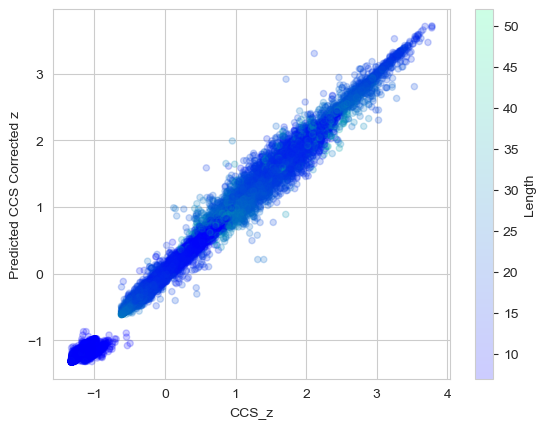

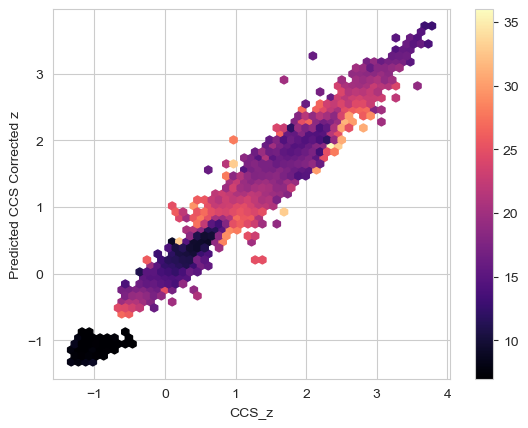

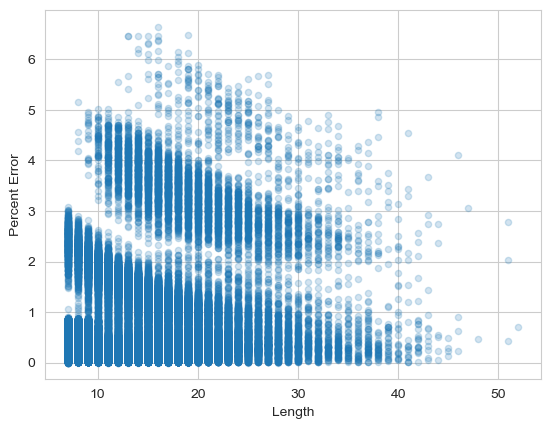

In [28]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
test_data.plot.scatter(
    x='CCS_z',
    y='Predicted CCS Corrected z',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
test_data.plot.hexbin(
    x='CCS_z',
    y='Predicted CCS Corrected z',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's  & Pearson's correlation coefficient between the predicted and actual CCS values
# Spearman uses rank (assumes a monotonic function), Pearson uses covariance and std to assess linear correlation
print("Spearman's Correlation Coefficient:", test_data['CCS_z'].corr(test_data['Predicted CCS Corrected z'], method='spearman'))
print("Pearson's Correlation Coefficient:", test_data['CCS_z'].corr(test_data['Predicted CCS Corrected z'], method='pearson'))
print("This is correlation on the test dataset, which has size:", len(test_data), "\n", "the whole dataset is", len(X))

# Create a scatter plot between the percent error and length
test_data['Percent Error'] = np.abs((test_data['Predicted CCS Corrected'] - test_data['CCS']) / test_data['CCS'])
test_data.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)

In [27]:
# parameters of final model
final_model

LinearRegression(n_jobs=-1)

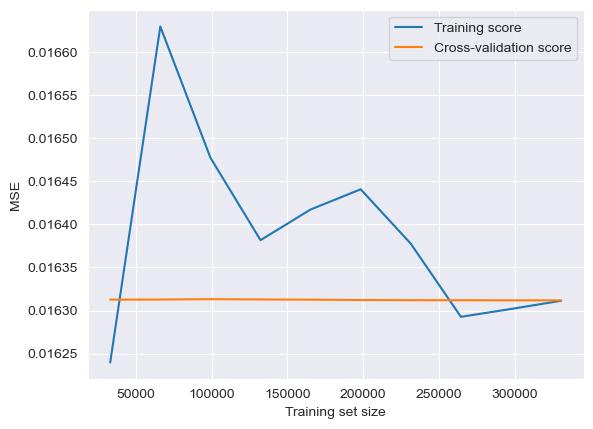

In [58]:
from sklearn.model_selection import learning_curve
# TODO: CHECK LEARNING CURVE AGAIN
# Define the sizes of the training sets to use
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(n_jobs=-1),
    X,
    y,
    train_sizes=train_sizes,
    cv=k,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Calculate the average training and test scores
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.xlabel('Training set size')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
print(X.shape)
print(y.shape)


Feature: 0, Score: 0.20562
Feature: 1, Score: 0.72117
Feature: 2, Score: 0.07321


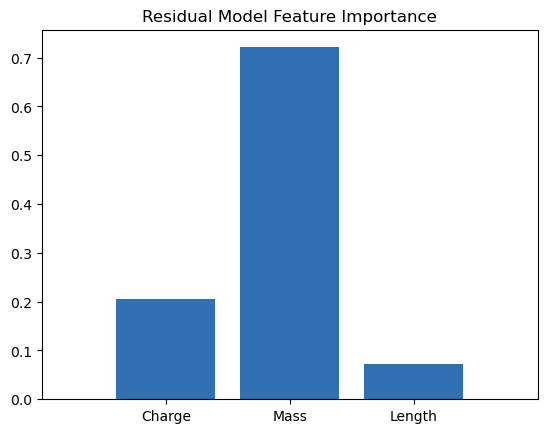

In [41]:
importance = final_residual_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
plt.title("Residual Model Feature Importance")
features = X.columns
plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
plt.xlim([-1, X.shape[1]])
plt.show()

Save the model

In [29]:
# Predict the CCS of the peptides in the data frame for whole data, on whole model
mb_clean_frame['Predicted CCS'] = final_model.predict(X)

# Reverse the z-score transformation
mb_clean_frame['Predicted CCS'] = mb_clean_frame['Predicted CCS'] * ccs_std + ccs_mean


Spearman's Correlation Coefficient: 0.9943845864618678
Pearson's Correlation Coefficient: 0.9918107872409009


/opt/anaconda3/envs/pbl/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1258: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='Length', ylabel='Percent Error'>

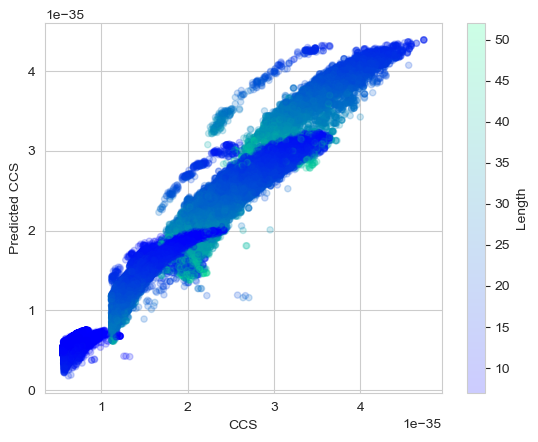

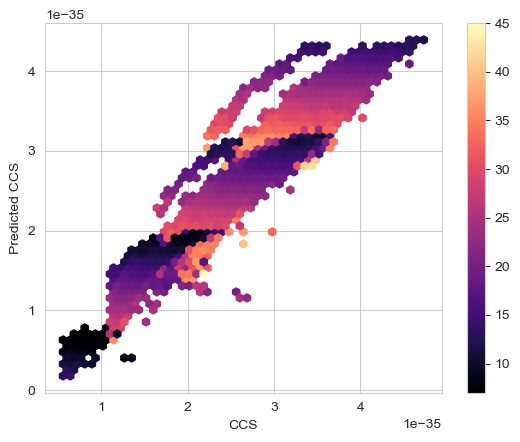

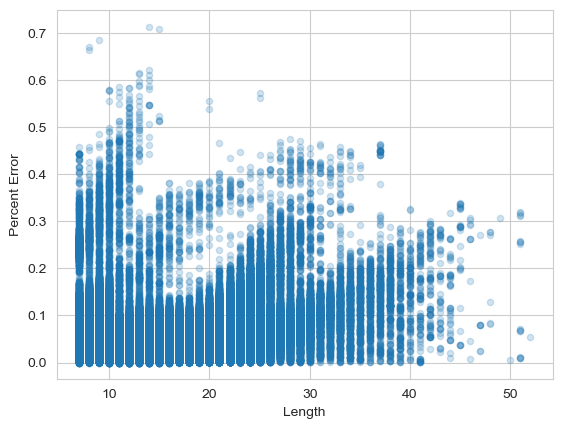

In [30]:
# Create a scatter plot of the error between the predicted and actual CCS values by sequence length. X = Experimental CCS, Y = Predicted CCS, Color = Sequence Length, Colormap = cool, alpha = 0.01
mb_clean_frame.plot.scatter(
    x='CCS',
    y='Predicted CCS',
    c='Length',
    cmap='winter',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)
mb_clean_frame.plot.hexbin(
    x='CCS',
    y='Predicted CCS',
    C='Length',
    reduce_C_function=np.mean,
    gridsize=50,
    cmap='magma'
)

# Print the Spearman's correlation coefficient between the predicted and actual CCS values
print("Spearman's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='spearman'))
print("Pearson's Correlation Coefficient:", mb_clean_frame['CCS'].corr(mb_clean_frame['Predicted CCS'], method='pearson'))

# Create a scatter plot between the percent error and length
mb_clean_frame['Percent Error'] = np.abs((mb_clean_frame['Predicted CCS'] - mb_clean_frame['CCS']) / mb_clean_frame['CCS'])
mb_clean_frame.plot.scatter(
    x='Length',
    y='Percent Error',
    alpha=0.2,
    vmin=mb_clean_frame['Length'].min(),
    vmax=mb_clean_frame['Length'].max()
)

Save the model to a file

In [ ]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))